### 0.0. Dependencies

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 1.1. Mobile App Data

#### 1.1.1. Loading in

In [4]:
## load mobile csv
mobile_csv = pd.read_csv("Data/Mobile_App_Data_Extract.csv")

In [81]:
print(mobile_csv.dtypes)

id                          int64
year                        int64
month                       int64
day                         int64
hour                        int64
acorn_group                object
home_country               object
work_country               object
home_distance_band_name    object
work_distance_band_name    object
events                      int64
dtype: object


In [5]:
print(len(mobile_csv))

47207158


In [6]:
#check cols
print(mobile_csv.columns)

Index(['id', 'year', 'month', 'day', 'hour', 'acorn_group', 'home_country',
       'work_country', 'home_distance_band_name', 'work_distance_band_name',
       'events'],
      dtype='object')


In [7]:
## load local footprint data
locF_lookup = pd.read_csv("Data/LOCF_ID_Look_Up.csv")
locF_data = pd.read_csv("Data/Retail_Footprint_24_INTS_Local_Footprint.csv")

In [82]:
print(locF_data.dtypes)

Centre_ID                                                  object
Name                                                       object
Short Name                                                 object
Region                                                     object
Major Class                                                 int64
Major Class Name                                           object
Minor Class                                                 int64
Minor Class Name                                           object
Base Score                                                  int64
Retail Footprint Score                                      int64
National Rank                                               int64
Regional Rank                                               int64
Total UK Centres                                            int64
Total Region Centres                                        int64
Total Class Centres                                         int64
Centre Typ

In [8]:
# check 
display(locF_lookup.sort_values(by='id').head())
print(locF_data.columns)


,id,LocF_CentreID,LocF_CentreName,CentroidX,CentroidY
1544,1,01-0001-22,London - Tooting,-0.165694,51.427946
183,2,01-0002-22,London - East Ham,0.052224,51.539347
2987,3,01-0003-22,London - Old Street,-0.090509,51.525846
803,4,01-0004-22,Hoxton,-0.093991,51.530838
2519,5,01-0005-22,London - Shepherds Bush,-0.225495,51.502832


Index(['Centre_ID', 'Name', 'Short Name', 'Region', 'Major Class',
       'Major Class Name', 'Minor Class', 'Minor Class Name', 'Base Score',
       'Retail Footprint Score', 'National Rank', 'Regional Rank',
       'Total UK Centres', 'Total Region Centres', 'Total Class Centres',
       'Centre Type Rank', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       '_Location_X', '_Location_Y', 'Tourism Score',
       'Local_Footprint_Centre_ID', 'Local_Footprint_Centre_Name', 'Town',
       'Universe_Region', 'Convenience_Score', 'Retail_Footprint_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Pr

In [9]:
## load locF shapefiles
locF_gdf = gpd.read_file("Data/Local_Footprint_Boundary.shp")
locF_gdf = locF_gdf.to_crs(epsg=27700)  # British National Grid

#### 1.1.2. LocF wrangling

Check for duplicates:

In [10]:
# check how many duplicate 'id' values exist
duplicate_ids = locF_lookup['id'].duplicated().sum()
print(f"Duplicate ids in locF_lookup: {duplicate_ids}")
# check duplicates in Local_Footprint_Centre_ID
duplicate_centres = locF_data['Local_Footprint_Centre_ID'].duplicated().sum()
print(f"Duplicate ids in locF_data: {duplicate_centres}")

Duplicate ids in locF_lookup: 0
Duplicate ids in locF_data: 92


In [11]:
## check for recurring Local Footprint Keys
recurring_keys = locF_data['Local_Footprint_Centre_ID'].value_counts()
recurring_keys = recurring_keys[recurring_keys > 1]
print(recurring_keys)

Local_Footprint_Centre_ID
01-0466-22    3
01-0330-22    3
01-0021-22    2
01-0001-22    2
08-0004-22    2
             ..
01-0015-22    2
55-0185-22    2
04-0002-22    2
01-0239-22    2
34-0222-22    2
Name: count, Length: 90, dtype: int64


In [12]:
# example dupliates
display(locF_data[locF_data['Local Footprint Key'] == '01-0466-22'])

,Centre_ID,Name,Short Name,Region,Major Class,Major Class Name,Minor Class,Minor Class Name,Base Score,Retail Footprint Score,...,Universe_Longitude,Universe_Latitude,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name,Local Footprint Key,Local Footprint Name
78,01-219,London - Shoreditch,Shoreditch,London,8,London Suburban Centres,22,Inner London Centres,433,449,...,-0.082537,51.523251,1,City Centre,110,Worker,1,Not seasonal,01-0466-22,London - Shoreditch - Scr
230,01-048,London - Old Street,Old Street,London,8,London Suburban Centres,22,Inner London Centres,157,165,...,-0.082537,51.523251,1,City Centre,110,Worker,1,Not seasonal,01-0466-22,London - Shoreditch - Scr
645,01-237,City of London - Broadgate,Broadgate,London,8,London Suburban Centres,19,London Workplaces,553,601,...,-0.082537,51.523251,1,City Centre,110,Worker,1,Not seasonal,01-0466-22,London - Shoreditch - Scr


Create new df without recurring Local Footprint IDs:

In [13]:
# column groups by aggregation type
group_key = 'Local_Footprint_Centre_ID'

cols_to_keep = [
    'Local Footprint Name','Region', 'Base Score', 'Retail Footprint Score', 'Residential Population (Weighted Catchment)',
    'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude', 'Tourism Score',
    'Local_Footprint_Centre_ID', 'Local_Footprint_Centre_Name', 'Convenience_Score',
    'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
    'Auto_Score', 'Services_Provided:_Convenience_Food',
    'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
    'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
    'Services_Provided:_Chemist', 'Services_Provided:_Banking',
    'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
    'Services_Provided:_Other_Convenience_Services',
    'Services_Provided:_Rail_or_Tube_Access',
    'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
    'Services_Provided:_Auto_Dealers', 'Services_Provided:_DIY', 'Major_Class',
    'Major_Class_Name', 'Minor_Class', 'Minor_Class_Name',
    'Seasonality_Class', 'Seasonality_Class_Name'
]

# ensure the dataframe only has relevant columns
df = locF_data[cols_to_keep].copy()

# define aggregation rules
agg_rules = {
    'Residential Population (Weighted Catchment)': 'sum',
    'Retail Footprint Score': 'mean',
    'Base Score': 'mean',
    'Tourism Score': 'mean',
    'Convenience_Score': 'mean',
    'Retail_Footprint_Comparison_Retailer_Score': 'mean',
    'Leisure_Footprint_Score': 'mean',
    'Auto_Score': 'mean'
}

# for all other columns, keep the first occurrence
for col in cols_to_keep:
    if col not in agg_rules and col != group_key:
        agg_rules[col] = 'first'

# columns where any True → final is True
bool_cols = [
    'Services_Provided:_Convenience_Food',
    'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
    'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
    'Services_Provided:_Chemist', 'Services_Provided:_Banking',
    'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
    'Services_Provided:_Other_Convenience_Services',
    'Services_Provided:_Rail_or_Tube_Access',
    'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
    'Services_Provided:_Auto_Dealers', 'Services_Provided:_DIY'
]

for col in bool_cols:
    df[col] = df[col].apply(lambda x: True if x == 'T' else False)
    agg_rules[col] = 'any'

# group and aggregate
df_cleaned = df.groupby(group_key, as_index=False).agg(agg_rules)

## check for recurring Local Footprint Keys
recurring_keys = df_cleaned['Local_Footprint_Centre_ID'].value_counts()
recurring_keys = recurring_keys[recurring_keys > 1]
print(recurring_keys)
print(df_cleaned.columns)
display(df_cleaned.head())

Series([], Name: count, dtype: int64)
Index(['Local_Footprint_Centre_ID',
       'Residential Population (Weighted Catchment)', 'Retail Footprint Score',
       'Base Score', 'Tourism Score', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Local Footprint Name', 'Region',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Local_Footprint_Centre_Name', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       'Services_Provided:_Auto_D

,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,...,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
0,01-0001-22,80102,394.5,366.0,65.703928,453.0,254.0,684.0,0.0,London - Tooting,...,True,True,False,True,4,Local High Street,401,Urban High Street,1,Not seasonal
1,01-0002-22,53781,389.0,358.0,25.178087,374.0,227.0,409.0,0.0,London - East Ham,...,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
2,01-0003-22,38043,307.0,295.0,670.667835,340.0,51.0,307.0,0.0,London - Old Street,...,True,True,False,False,1,City Centre,110,Worker,1,Not seasonal
3,01-0004-22,7862,165.0,157.0,715.736173,326.0,0.0,11.0,0.0,Hoxton,...,False,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
4,01-0005-22,13418,423.0,398.0,160.154406,368.0,169.0,698.0,0.0,London - Shepherds Bush,...,True,True,False,True,1,City Centre,103,Secondary Retail,1,Not seasonal


#### 1.1.3. Mobile wrangling

Date-time conversion:

In [14]:
print(mobile_csv['hour'].unique())

[ 9  5 11 10 15 22 16  8 14 21 19 13  6 18 17 20  4 12  0  7 23  1  3  2]


In [15]:
mobile_csv_convert = mobile_csv.copy()
mobile_csv_convert['datetime'] = pd.to_datetime(dict(
    year=mobile_csv_convert['year'],
    month=mobile_csv_convert['month'],
    day=mobile_csv_convert['day'],
    hour=mobile_csv_convert['hour']
))
mobile_csv_convert = mobile_csv_convert.drop(columns=['year', 'month', 'day', 'hour'])


Check the data:

In [16]:
display(mobile_csv_convert.head())

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime
0,27980,N,United Kingdom,United Kingdom,50 km +,50 km +,22,2024-04-05 09:00:00
1,20944,R,United Kingdom,United Kingdom,00 - 01 km,00 - 01 km,25,2024-02-14 09:00:00
2,3864,N,United Kingdom,United Kingdom,00 - 01 km,50 km +,3,2024-01-23 05:00:00
3,1334,G,United Kingdom,United Kingdom,05 - 10 km,00 - 01 km,26,2024-08-23 11:00:00
4,8903,F,United Kingdom,United Kingdom,40 - 45 km,40 - 45 km,21,2024-02-21 10:00:00


In [17]:
display(mobile_csv_convert.sort_values(by='id').head())

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime
25310044,1,E,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,4,2024-03-29 14:00:00
251,1,G,United Kingdom,United Kingdom,10 - 15 km,50 km +,21,2024-10-31 13:00:00
40660053,1,N,United Kingdom,United Kingdom,01 - 05 km,0 - 05 km,2,2024-02-14 14:00:00
30009782,1,H,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,5,2024-04-17 00:00:00
45286495,1,J,United Kingdom,United Kingdom,05 - 10 km,0 - 05 km,1,2024-10-23 13:00:00


In [18]:
df_filtered = mobile_csv_convert[mobile_csv_convert['id'] == 20944].sort_values(by='datetime')
display(df_filtered.iloc[50:60][['datetime']])

,datetime
17593705,2024-01-01 16:00:00
38815683,2024-01-01 16:00:00
26216004,2024-01-01 16:00:00
10485045,2024-01-01 17:00:00
32343640,2024-01-01 17:00:00
24582281,2024-01-01 17:00:00
28033286,2024-01-01 17:00:00
33152362,2024-01-01 17:00:00
46628795,2024-01-01 18:00:00
40776243,2024-01-01 18:00:00


Plot hourly footfall:

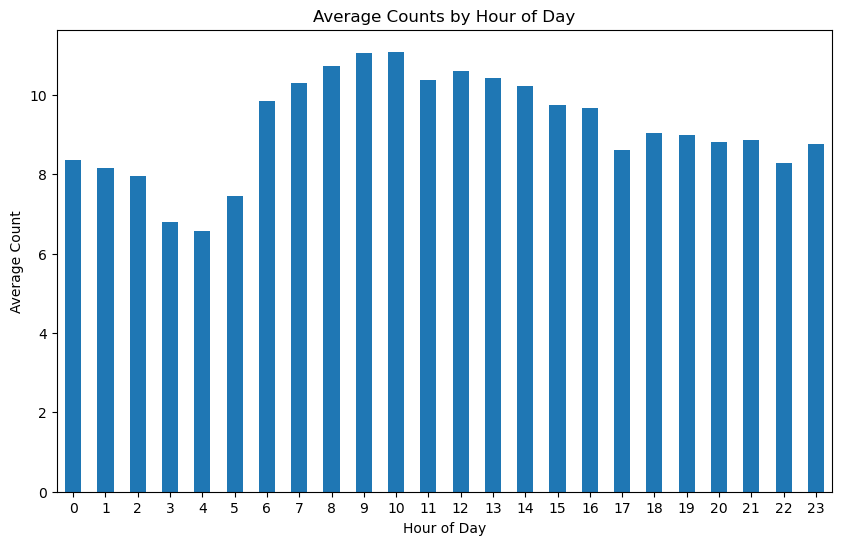

In [19]:
# extract hour from datetime
df_filtered['hour'] = df_filtered['datetime'].dt.hour

# group by hour and compute average count
avg_counts_by_hour = df_filtered.groupby('hour')['events'].mean()

# plot
plt.figure(figsize=(10,6))
avg_counts_by_hour.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.title('Average Counts by Hour of Day')
plt.xticks(rotation=0)
plt.show()

Generate daily footfall counts:

In [20]:
# extract date (without time) from datetime
mobile_csv_convert['date'] = mobile_csv_convert['datetime'].dt.date

# group by date and id, then sum events
mobile_daily = (
    mobile_csv_convert
    .groupby(['date', 'id'])['events']
    .sum()
    .reset_index()
)

display(mobile_csv_convert)
display(mobile_daily.head())
len(mobile_daily)

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime,date
0,27980,N,United Kingdom,United Kingdom,50 km +,50 km +,22,2024-04-05 09:00:00,2024-04-05
1,20944,R,United Kingdom,United Kingdom,00 - 01 km,00 - 01 km,25,2024-02-14 09:00:00,2024-02-14
2,3864,N,United Kingdom,United Kingdom,00 - 01 km,50 km +,3,2024-01-23 05:00:00,2024-01-23
3,1334,G,United Kingdom,United Kingdom,05 - 10 km,00 - 01 km,26,2024-08-23 11:00:00,2024-08-23
4,8903,F,United Kingdom,United Kingdom,40 - 45 km,40 - 45 km,21,2024-02-21 10:00:00,2024-02-21
...,...,...,...,...,...,...,...,...,...
47207153,18929,U,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,1,2024-01-26 10:00:00,2024-01-26
47207154,48,S,United Kingdom,United Kingdom,10 - 15 km,00 - 01 km,2,2024-03-21 15:00:00,2024-03-21
47207155,2577,E,United Kingdom,United Kingdom,05 - 10 km,05 - 10 km,1,2024-06-06 11:00:00,2024-06-06
47207156,26004,K,United Kingdom,United Kingdom,01 - 05 km,50 km +,2,2024-07-07 14:00:00,2024-07-07


,date,id,events
0,2024-01-01,1,1714
1,2024-01-01,2,3148
2,2024-01-01,3,692
3,2024-01-01,4,27
4,2024-01-01,5,2164


1059996

Determine weekday/weekend season:

In [21]:
mobile_daily['date'] = pd.to_datetime(mobile_daily['date'])

# add weekend column (True if Saturday or Sunday)
mobile_daily['weekend'] = mobile_daily['date'].dt.dayofweek >= 5

# define a function to assign seasons (Northern Hemisphere, 2024)
def get_season(date):
    Y = date.year
    if pd.Timestamp(f'{Y}-03-20') <= date < pd.Timestamp(f'{Y}-06-20'):
        return 'Spring'
    elif pd.Timestamp(f'{Y}-06-20') <= date < pd.Timestamp(f'{Y}-09-22'):
        return 'Summer'
    elif pd.Timestamp(f'{Y}-09-22') <= date < pd.Timestamp(f'{Y}-12-21'):
        return 'Autumn'
    else:
        return 'Winter'

# add season column
mobile_daily['season'] = mobile_daily['date'].apply(get_season)

# display updated DataFrame
display(mobile_daily.head())

,date,id,events,weekend,season
0,2024-01-01,1,1714,False,Winter
1,2024-01-01,2,3148,False,Winter
2,2024-01-01,3,692,False,Winter
3,2024-01-01,4,27,False,Winter
4,2024-01-01,5,2164,False,Winter


Determine holidays:

In [22]:
# define UK bank holidays in 2024
uk_holidays_2024 = pd.to_datetime([
    '2024-01-01',  # New Year’s Day
    '2024-03-29',  # Good Friday
    '2024-04-01',  # Easter Monday
    '2024-05-06',  # Early May bank holiday
    '2024-05-27',  # Spring bank holiday
    '2024-08-26',  # Summer bank holiday
    '2024-12-25',  # Christmas Day
    '2024-12-26'   # Boxing Day
])

# add holiday column (True if the date is a holiday)
mobile_daily['holiday'] = mobile_daily['date'].isin(uk_holidays_2024)

# display updated df
display(mobile_daily.head())

,date,id,events,weekend,season,holiday
0,2024-01-01,1,1714,False,Winter,True
1,2024-01-01,2,3148,False,Winter,True
2,2024-01-01,3,692,False,Winter,True
3,2024-01-01,4,27,False,Winter,True
4,2024-01-01,5,2164,False,Winter,True


#### 1.1.4. Merging

Mobile & locF data merge:

In [23]:
## join locF id with mobile data based on lookup table 
mobile_locF = mobile_daily.merge(locF_lookup[['id', 'LocF_CentreID']], how='left', on='id')

In [24]:
## join locF data with mobile data
mobile_locF = mobile_locF.merge(df_cleaned, how='left', left_on='LocF_CentreID', right_on='Local_Footprint_Centre_ID')
mobile_locF = mobile_locF.drop(columns=['LocF_CentreID']) # drop redundant column

In [25]:
# check the number or rows matches the initial mobile data 
print(len(mobile_daily))
print(len(mobile_locF))

1059996
1059996


In [26]:
# check cols
print(mobile_locF.columns)


Index(['date', 'id', 'events', 'weekend', 'season', 'holiday',
       'Local_Footprint_Centre_ID',
       'Residential Population (Weighted Catchment)', 'Retail Footprint Score',
       'Base Score', 'Tourism Score', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Local Footprint Name', 'Region',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Local_Footprint_Centre_Name', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       '

In [27]:
# display all columns and their values for the first few rows
with pd.option_context('display.max_columns', None, 'display.width', None):
    display(mobile_locF.head())

,date,id,events,weekend,season,holiday,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,Region,Spend Per Head (Residential),Sparsity,Longitude,Latitude,Local_Footprint_Centre_Name,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
0,2024-01-01,1,1714,False,Winter,True,01-0001-22,80102,394.5,366.0,65.703928,453.0,254.0,684.0,0.0,London - Tooting,London,1933.087727,5 - Urban Dense (London),-0.166467,51.428020,London - Tooting,True,True,True,True,True,True,True,True,True,True,True,True,False,True,4,Local High Street,401,Urban High Street,1,Not seasonal
1,2024-01-01,2,3148,False,Winter,True,01-0002-22,53781,389.0,358.0,25.178087,374.0,227.0,409.0,0.0,London - East Ham,London,1733.492583,5 - Urban Dense (London),0.054717,51.540270,London - East Ham,True,True,True,True,True,True,True,True,True,True,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
2,2024-01-01,3,692,False,Winter,True,01-0003-22,38043,307.0,295.0,670.667835,340.0,51.0,307.0,0.0,London - Old Street,London,1812.007827,5 - Urban Dense (London),-0.075624,51.528560,London - Old Street,True,True,True,True,True,False,True,True,True,True,True,True,False,False,1,City Centre,110,Worker,1,Not seasonal
3,2024-01-01,4,27,False,Winter,True,01-0004-22,7862,165.0,157.0,715.736173,326.0,0.0,11.0,0.0,Hoxton,London,1892.654325,5 - Urban Dense (London),-0.091799,51.526522,Hoxton,True,True,False,True,False,False,True,True,True,False,False,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
4,2024-01-01,5,2164,False,Winter,True,01-0005-22,13418,423.0,398.0,160.154406,368.0,169.0,698.0,0.0,London - Shepherds Bush,London,1972.601453,5 - Urban Dense (London),-0.227470,51.502096,London - Shepherds Bush,True,True,True,True,True,True,True,True,True,True,True,True,False,True,1,City Centre,103,Secondary Retail,1,Not seasonal


Check for NAs:

In [28]:
# print NA sums
display(mobile_locF.isna().sum())

date                                                          0
id                                                            0
events                                                        0
weekend                                                       0
season                                                        0
holiday                                                       0
Local_Footprint_Centre_ID                                     0
Residential Population (Weighted Catchment)                   0
Retail Footprint Score                                        0
Base Score                                                    0
Tourism Score                                             10533
Convenience_Score                                             0
Retail_Footprint_Comparison_Retailer_Score                    0
Leisure_Footprint_Score                                       0
Auto_Score                                                    0
Local Footprint Name                    

In [29]:
na_tourism = mobile_locF[mobile_locF['Tourism Score'].isna()]
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(na_tourism)

,date,id,events,weekend,season,holiday,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,Region,Spend Per Head (Residential),Sparsity,Longitude,Latitude,Local_Footprint_Centre_Name,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
305,2024-01-01,1350,1348,False,Winter,True,02-0153-22,0,343.0,300.0,NaN,50.0,249.0,70.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.487946,51.471608,London Heathrow Airport - Terminal 5,True,True,True,False,True,False,False,True,False,False,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
324,2024-01-01,1459,1447,False,Winter,True,02-0262-22,0,182.0,160.0,NaN,37.0,157.0,68.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.451302,51.470321,London Heathrow Airport - Terminal 2,False,True,False,False,True,False,False,True,True,True,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
359,2024-01-01,1614,748,False,Winter,True,02-0416-22,0,215.0,189.0,NaN,20.0,97.0,44.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.458626,51.470903,London Heathrow Airport - Terminal 3,True,True,False,False,True,False,False,True,True,False,True,True,False,False,4,Local High Street,401,Urban High Street,6,Winter months
700,2024-01-01,5834,101,False,Winter,True,05-0125-22,0,29.0,29.0,NaN,13.0,0.0,99.0,0.0,Doncaster - Dome Leisure,Yorkshire and The Humber,0.00000,6 - Retail Park,-1.104043,53.514081,Doncaster - Dome Leisure Park,True,False,False,False,False,False,True,True,False,False,False,True,False,False,3,Retail Park,304,Leisure Park,1,Not seasonal
733,2024-01-01,6156,32,False,Winter,True,05-0444-24,20252,138.0,161.0,NaN,26.0,103.0,35.0,0.0,Stocksbridge - Fox Valley,Yorkshire and The Humber,2155.71929,2 - Small Urban,-1.586133,53.482745,Stocksbridge - Fox Valley Shopping Park,True,True,False,True,True,False,False,True,True,False,True,True,False,True,0,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059544,2024-12-31,30069,474,False,Winter,False,44-0500-22,0,343.0,300.0,NaN,1.0,0.0,0.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.487946,51.471608,London Heathrow Airport - Terminal 5 Tube Station,False,False,False,False,False,False,False,False,False,True,False,False,False,False,5,Local Parade,109,Convenience and Services,1,Not seasonal
1059562,2024-12-31,30277,20,False,Winter,False,45-0067-22,0,22.0,23.0,NaN,21.0,7.0,35.0,0.0,Corley Services,West Midlands,0.00000,2 - Small Urban,-1.546500,52.471368,Corley Services,True,False,False,False,False,False,True,True,False,False,True,True,False,False,7,Transient,701,Motorway,2,Warm months
1059577,2024-12-31,30667,580,False,Winter,False,46-0053-22,0,188.0,213.0,NaN,49.0,140.0,144.0,0.0,London Gatwick Airport -,South East,0.00000,2 - Small Urban,-0.162786,51.156015,London Gatwick Airport - South Terminal,True,True,False,False,True,False,True,True,True,False,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
1059585,2024-12-31,30895,95,False,Winter,False,46-0281-22,0,188.0,213.0,NaN,1.0,1.0,5.0,0.0,London Gatwick Airport Ra,South East,0.00000,2 - Small Urban,-0

In [30]:
na_class = mobile_locF[mobile_locF['Major_Class_Name'].isna()]
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(na_class)

,date,id,events,weekend,season,holiday,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,Region,Spend Per Head (Residential),Sparsity,Longitude,Latitude,Local_Footprint_Centre_Name,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
137,2024-01-01,418,153,False,Winter,True,01-0417-24,7862,165.0,157.0,715.736173,20.0,0.0,16.0,0.0,Hoxton - Murray Grove,London,1892.654325,5 - Urban Dense (London),-0.091799,51.526522,Hoxton - Murray Grove,True,True,True,False,True,False,False,True,True,False,False,True,False,False,0,None,0,None,0,None
179,2024-01-01,615,65,False,Winter,True,01-0610-24,30897,211.0,219.0,71.370285,9.0,94.0,9.0,0.0,London - Bell Green,London,1810.689108,6 - Retail Park,-0.034461,51.429477,London - Bell Green,True,False,False,False,False,False,False,True,True,False,True,True,False,True,0,None,0,None,0,None
235,2024-01-01,1074,75,False,Winter,True,01-1063-24,38043,307.0,295.0,670.667835,2.0,0.0,3.0,0.0,Hoxton - New North Road,London,1812.007827,5 - Urban Dense (London),-0.075624,51.528560,Hoxton - New North Road,True,False,False,True,False,False,False,False,False,False,False,True,False,False,0,None,0,None,0,None
236,2024-01-01,1076,22,False,Winter,True,01-1064-24,3847,162.0,153.0,378.022527,1.0,0.0,8.0,0.0,Kensington - West Cromwel,London,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,Kensington - West Cromwell Road,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0,None,0,None,0,None
237,2024-01-01,1078,20,False,Winter,True,01-1065-24,3847,162.0,153.0,378.022527,1.0,0.0,4.0,0.0,London - Kensington - Cro,London,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,London - Kensington - Cromwell Road - 2,False,True,False,False,False,False,False,False,False,False,False,True,False,False,0,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058725,2024-12-31,17968,181,False,Winter,False,23-0460-24,30349,240.0,268.0,49.804403,23.0,57.0,24.0,0.0,Maldon - Blackwater Retai,East of England,2237.503734,2 - Small Urban,0.677783,51.733167,Maldon - Blackwater Retail Park,True,True,False,False,True,False,True,True,True,False,True,True,False,False,0,None,0,None,0,None
1058774,2024-12-31,18624,12,False,Winter,False,24-0126-24,7806,104.0,106.0,10.176248,6.0,8.0,17.0,0.0,Gloucester - Quedgeley -,South West,1989.192093,3 - Urban,-2.277118,51.826750,Gloucester - Quedgeley - Bristol Road,False,False,True,False,False,False,True,False,False,False,True,True,False,False,0,None,0,None,0,None
1058831,2024-12-31,19223,11,False,Winter,False,25-0320-24,7442,111.0,114.0,18.354529,6.0,5.0,28.0,0.0,Portsmouth - Binnacle Way,South East,2051.948744,3 - Urban,-1.096318,50.846401,Portsmouth - Binnacle Way,False,True,False,False,False,False,False,True,False,False,True,True,False,False,0,None,0,None,0,None
1059435,2024-12-31,28056,42,False,Winter,False,41-0075-24,13029,132.0,147.0,38.977113,8.0,25.0,9.0,2.0,Shepton Mallet - High Str,South West,1992.380796,1 - Rural,-2.546504,51.189391,Shepton Mallet - High Street,False,False,False,False,False,False,False,True,False,False,True,True,True,False,0,None,0,None,0,None


GeoData merge:

In [31]:
print(locF_gdf.columns)

Index(['Local_Foot', 'geometry'], dtype='object')


In [32]:
# get rows with duplicated Local_Foot values
duplicates = locF_gdf[locF_gdf['Local_Foot'].duplicated(keep=False)]
# sort so duplicate groups are adjacent
duplicates = duplicates.sort_values(by='Local_Foot')
# display info
print(f"Number of duplicate 'Local_Foot' values: {duplicates['Local_Foot'].nunique()}")
display(duplicates)

Number of duplicate 'Local_Foot' values: 90


,Local_Foot,geometry
142,01-0001-22,"POLYGON ((527684.669 172540.771, 527676.696 17..."
75,01-0001-22,"POLYGON ((527684.669 172540.771, 527676.696 17..."
79,01-0003-22,"MULTIPOLYGON (((532775.733 182730.793, 532794...."
231,01-0003-22,"MULTIPOLYGON (((532775.733 182730.793, 532794...."
69,01-0009-22,"POLYGON ((530260.754 175176.804, 530275.709 17..."
...,...,...
2430,63-0260-22,"POLYGON ((257066.733 666676.716, 257074.784 66..."
2688,63-0472-22,"POLYGON ((257857.769 666078.666, 257858.777 66..."
654,63-0472-22,"POLYGON ((257857.769 666078.666, 257858.777 66..."
2406,63-1089-22,"POLYGON ((257126.777 666905.639, 257127.748 66..."


We can see the geometry is identical, so let's get rid of duplicate occurences. 

In [33]:
locF_gdf = locF_gdf.drop_duplicates(subset='Local_Foot', keep='first')
len(locF_gdf)

2999

In [34]:
## merge with gdf
mobile_locF_gdf= locF_gdf.merge(mobile_locF, left_on='Local_Foot', right_on='Local_Footprint_Centre_ID', how='left')
mobile_locF_gdf = mobile_locF_gdf.drop(columns=['Local_Foot'])

In [35]:
print(mobile_locF_gdf.columns)
print(len(mobile_daily))
print(len(mobile_locF_gdf))

Index(['geometry', 'date', 'id', 'events', 'weekend', 'season', 'holiday',
       'Local_Footprint_Centre_ID',
       'Residential Population (Weighted Catchment)', 'Retail Footprint Score',
       'Base Score', 'Tourism Score', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Local Footprint Name', 'Region',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Local_Footprint_Centre_Name', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisur

In [84]:
print("Unique Major Classes:", mobile_locF_gdf['Major_Class_Name'].unique())
print("Unique Minor Classes:", mobile_locF_gdf['Minor_Class_Name'].unique())

Unique Major Classes: ['Standalone' 'City Centre' 'Retail Park' 'Transient' 'Local High Street'
 'Local Parade' 'Retail Destination' None]
Unique Minor Classes: ['Residential' 'Convenience and Services' 'Leisure Park'
 'Secondary Retail' 'Major Retail' 'Station'
 'Specialist Eating and Drinking' 'Small Urban Parade' 'Worker'
 'Mainstream Eating and Drinking' 'Convenience' 'Urban High Street'
 'Strong Urban Parade' 'Discount Retail' 'Pharmacy'
 'Independent Bars Cafes and Restaurants' 'Local Mall' None
 'Regional Mall' 'Retail Park' 'Late Night Entertainment'
 'Small Takeaway and Catering' 'Premium Retail' 'Supermarket'
 'Major Urban Centre' 'Independent Retail' 'Outlet Centre'
 'Railway and Underground Station' 'Regional Town' 'Catering'
 'Shopping Park' 'Bank or Building Society' 'Petrol Station'
 'Local Rural Centre' 'Local Town' 'Small Rural Centre' 'Rural Centre'
 'Motorway']


### 1.2. Retail Typology Data

#### 1.2.1. Loading in

In [3]:
typology = gpd.read_file("Data/typology_2022.gpkg")
typology = typology.to_crs(epsg=27700)

In [5]:
print(typology['supergroupName'].unique())
print(typology['groupName'].unique())

["Local 'everyday' goods and service centres" 'Retail and shopping parks'
 'Leading comparison and leisure destinations'
 'Traditional high streets and market towns']
['Local urban convenience centres' 'District urban service centres'
 'Secondary retail parks and shopping centres'
 'Large regional retail and leisure destinations'
 'Mass and value high streets' 'Indie high streets'
 'Sub-regional retail and leisure destinations'
 'Primary shopping centres and premium destinations']


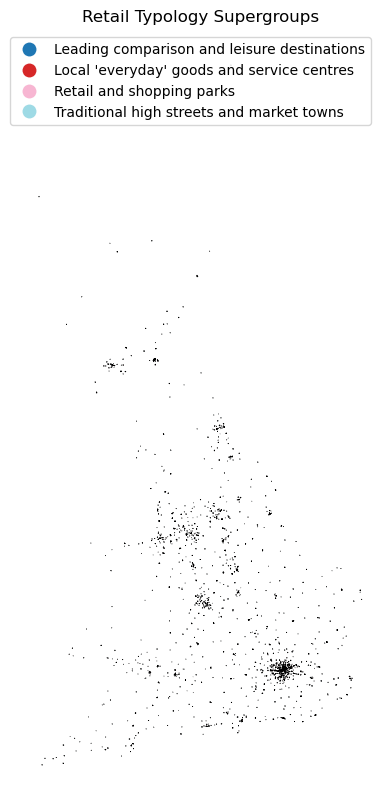

In [65]:
# plot the typology GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
typology.plot(column="supergroupName", ax=ax, legend=True, cmap="tab20", edgecolor="black", linewidth=0.5)
ax.set_title("Retail Typology Supergroups")
ax.set_axis_off()
plt.show()

#### 1.2.2. Spatial intersection

In [66]:
# Step 1: Spatial intersection
intersected = gpd.overlay(mobile_locF_gdf, typology, how='intersection')

# Step 2: Add area column for filtering
intersected['area'] = intersected.geometry.area

# Step 3: Sort by area descending so largest is on top
intersected_sorted = intersected.sort_values('area', ascending=False)

# Step 4: Drop duplicates, keeping only the largest (first) for each ID
retail_areas = intersected_sorted.drop_duplicates(
    subset=['Local_Footprint_Centre_ID', 'date'], 
    keep='first'
)

# drop the temporary area column if no longer needed
retail_areas = retail_areas.drop(columns='area')

In [67]:
print(len(locF_gdf))
len(retail_areas)

2999


524131

In [68]:
display(retail_areas.head())

,date,id,events,weekend,season,holiday,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,...,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name,RC_ID,RC_Name,supergroupID,supergroupName,groupID,groupName,geometry
436970,2024-01-07,17519,475,True,Winter,False,23-0014-22,65064,767.0,802.0,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436969,2024-01-06,17519,1365,True,Winter,False,23-0014-22,65064,767.0,802.0,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436988,2024-01-25,17519,394,False,Winter,False,23-0014-22,65064,767.0,802.0,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436971,2024-01-08,17519,575,False,Winter,False,23-0014-22,65064,767.0,802.0,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436979,2024-01-16,17519,741,False,Winter,False,23-0014-22,65064,767.0,802.0,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."


### 1.3. Coastal Identifier

#### 1.3.1. Load GADm data

In [69]:
uk_boundary = gpd.read_file("Data/UK_boundary/gadm41_GBR_0.shp")

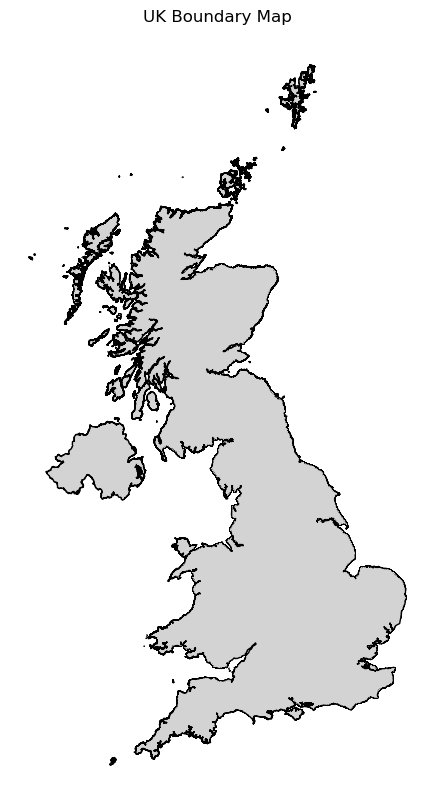

In [70]:
uk_boundary.plot(figsize=(8, 10), edgecolor='black', facecolor='lightgray')
plt.title("UK Boundary Map")
plt.axis('off')
plt.show()

In [71]:
print("retail_areas CRS:", retail_areas.crs)
print("uk_boundary CRS:", uk_boundary.crs)

retail_areas CRS: EPSG:27700
uk_boundary CRS: EPSG:4326


In [72]:
uk_boundary = uk_boundary.to_crs(retail_areas.crs)

In [73]:
uk_buffer = uk_boundary.buffer(-2000)

In [74]:
uk_buffer_gdf = gpd.GeoDataFrame(geometry=uk_buffer, crs=uk_boundary.crs)
uk_buffer_gdf.to_file("uk_buffer.gpkg", layer="uk_buffer", driver="GPKG")

In [75]:
# ensure uk_geom is a single unified geometry
if isinstance(uk_buffer, gpd.GeoDataFrame):
    uk_geom = uk_buffer.geometry.union_all()
elif isinstance(uk_buffer, gpd.GeoSeries):
    uk_geom = uk_buffer.union_all()
else:
    uk_geom = uk_buffer  # already a geometry

In [76]:
# if centroid is outside of buffer, classify as 'coastal'
retail_areas['coastal'] = retail_areas.geometry.centroid.apply(
    lambda pt: 'coastal' if not pt.within(uk_geom) else 'inland'
)

In [78]:
display(retail_areas.head())

,date,id,events,weekend,season,holiday,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,...,Seasonality_Class,Seasonality_Class_Name,RC_ID,RC_Name,supergroupID,supergroupName,groupID,groupName,geometry,coastal
436970,2024-01-07,17519,475,True,Winter,False,23-0014-22,65064,767.0,802.0,...,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17...",inland
436969,2024-01-06,17519,1365,True,Winter,False,23-0014-22,65064,767.0,802.0,...,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17...",inland
436988,2024-01-25,17519,394,False,Winter,False,23-0014-22,65064,767.0,802.0,...,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17...",inland
436971,2024-01-08,17519,575,False,Winter,False,23-0014-22,65064,767.0,802.0,...,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17...",inland
436979,2024-01-16,17519,741,False,Winter,False,23-0014-22,65064,767.0,802.0,...,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17...",inland


In [77]:
# write the retail_areas GeoDataFrame to a GeoPackage
retail_areas.to_file("retail_areas.gpkg", layer="retail_areas", driver="GPKG")